In [20]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

In [21]:
# Load Data
df = pd.read_csv('https://raw.githubusercontent.com/flyandlure/datasets/master/housing.csv')
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [22]:
# As ocean proximity has a categotrical value, so converting to numerical value using one hot encoding
df['ocean_proximity'] = df['ocean_proximity'].str.lower().replace('[^0-9a-zA-Z]+','_',regex=True)
encodings = pd.get_dummies(df['ocean_proximity'], prefix='proximity')
df = pd.concat([df, encodings], axis=1)

In [23]:
#As the median_income column looks to be very highly correlated with the target variable median_house_value, we’ll try binning the data to see if that helps our score.
income_labels = ['5','4','3', '2', '1']
df['income_bin'] = pd.cut(df['median_income'], bins=5, labels=income_labels).astype(int)

In [24]:
# Removing outliers above 500000
df = df.loc[df['median_house_value']<500000,:]

In [25]:
#Remove collinear features
df = df.drop(["households","total_bedrooms","population"],axis=1)

In [26]:
#There are only a few (207) missing values in the data set and zero imputation (filling the missing values in with zeroes) performed well before, so we’ll repeat that step.
df = df.fillna(0)

In [27]:
# Crrating X and Y features
X = df.drop(['median_house_value','ocean_proximity'], axis=1)
y = df['median_house_value']

In [28]:
#Create training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [31]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
#create a dictionary containing the name of each model we want to test, and the name of the model class
regressors = {
    "XGBRegressor": XGBRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "LinearSVR": LinearSVR(),
    "KernelRidge": KernelRidge(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [33]:
#Next we’ll create a Pandas dataframe into which we’ll store the data. Then we’ll loop over each of the models, 
#fit it using the X_train and y_train data, then generate predictions from X_test and calculate the mean RMSE from 10 rounds of cross-validation.
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'rmse_cv'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'rmse_cv': round(np.mean(np.sqrt(-scores)))
    }

    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor


C:\Users\user\AppData\Local\Temp\ipykernel_13228\2806980095.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* RandomForestRegressor


C:\Users\user\AppData\Local\Temp\ipykernel_13228\2806980095.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* DecisionTreeRegressor


C:\Users\user\AppData\Local\Temp\ipykernel_13228\2806980095.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* GaussianProcessRegressor


KeyboardInterrupt: 

In [13]:
df_models.head(20).sort_values(by='rmse_cv', ascending=True)

,model,run_time,rmse,rmse_cv
0,XGBRegressor,0.27,44292,44041
1,RandomForestRegressor,1.52,44787,44857
2,DecisionTreeRegressor,0.03,60684,61863
8,LinearRegression,0.0,62981,62635
9,Ridge,0.0,62982,62637
10,Lars,0.0,62981,62637
15,BayesianRidge,0.0,62985,62637
14,ARDRegression,0.04,62967,62647
12,HuberRegressor,0.02,63931,63410
13,PassiveAggressiveRegressor,0.09,64676,64040


In [14]:
# Using the best model and visualizing its prredictions
regressor = XGBRegressor()
model = regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

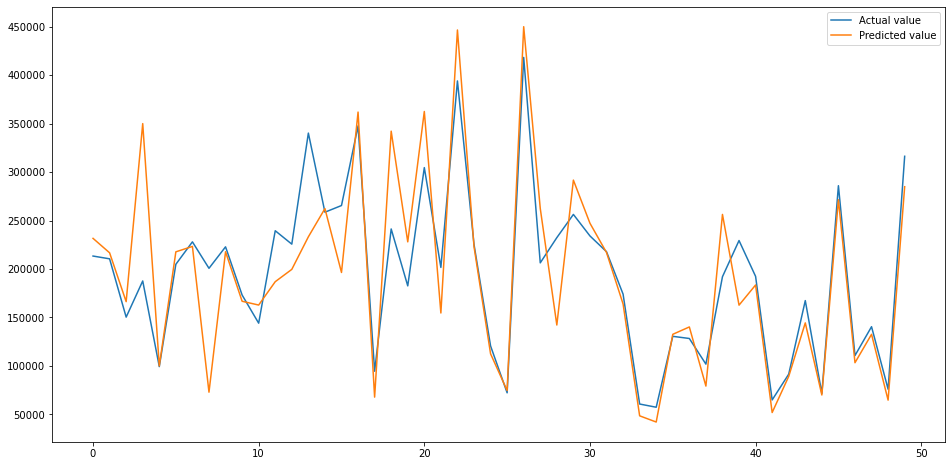

In [15]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])

In [16]:
#to determine which hyperparameters are available for tuning
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [ ]:
#Next, take a small selection of the hyperparameters and add them to a dict() and assign this to the param_grid. 
#We’ll then define the model and configure the GridSearchCV function to test each unique combination of hyperparameters 
param_grid = dict(
    n_jobs=[16],
    learning_rate=[0.1, 0.5],
    objective=['reg:squarederror'],
    max_depth=[5, 10, 15], 
    n_estimators=[100, 500, 1000],
    subsample=[0.2, 0.8, 1.0],
    gamma=[0.05, 0.5],
    scale_pos_weight=[0, 1],
    reg_alpha=[0, 0.5],
    reg_lambda=[1, 0],
)

model = XGBRegressor(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           )

best_model = grid_search.fit(X_train, y_train)
print('Optimum parameters', best_model.best_params_)

In [ ]:
#take the optimum parameters identified by GridSearchCV and add them to the XGBRegressor() model and re-fit it to your 
#training data, generating new predictions from the test data
regressor = XGBRegressor(
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,
    n_jobs=16,
    objective='reg:squarederror',
    subsample=0.8,
    scale_pos_weight=0,
    reg_alpha=0,
    reg_lambda=1
)
model = regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual value','Predicted value'])